In [13]:
import sqlite3
import os
import pandas as pd

dataset = r'yuanyoudataset'

# dataset = r'C:\Users\Administrator\Desktop'    

# 预测价格数据
# dbfilename = os.path.join(r'D:\code\PriceForecast\yuanyoudataset','jbsh_yuanyou.db')
# conn = sqlite3.connect(dbfilename)
# query = 'SELECT * FROM accuracy'
# df1 = pd.read_sql_query(query, conn)
# df1['ds'] =  df1['PREDICT_DATE']
# conn.close()
# print(df1.shape)

# 预测价格数据
dfcsvfilename = os.path.join(dataset,'accuracy_five_mean.csv')
df1 = pd.read_csv(dfcsvfilename)
print(df1.shape)

# 最高最低价
xlsfilename = os.path.join(dataset,'数据项下载.xls')
df2 = pd.read_excel(xlsfilename)[5:]
df2 = df2.rename(columns = {'数据项名称':'ds','布伦特最低价':'LOW_PRICE','布伦特最高价':'HIGH_PRICE'})
print(df2.shape)



df = pd.merge(df1,df2,on=['ds'],how='left')

df['ds'] =  pd.to_datetime(df['ds'])
# df['PREDICT_DATE'] =  pd.to_datetime(df['PREDICT_DATE'])
df = df.reindex()

print(df.shape)
# from datetime import datetime
import time
df.to_csv(os.path.join(dataset,f'预测数据-{time.time()}.csv'))
# df = df[['ds','min_within_quantile','max_within_quantile']]



# 打印数据框的前几行
print(df.head())
print(df.tail())


(255, 28)
(78, 4)
(255, 31)
          ds     NHITS   Informer       LSTM  iTransformer    TSMixer  \
0 2024-10-08  79.76823  80.197660  79.802414     78.391460  80.200510   
1 2024-10-09  78.75903  80.235740  79.844154     78.888565  79.861180   
2 2024-10-10  79.43970  80.186230  79.885100     79.488700  79.483086   
3 2024-10-11  79.62268  80.502975  79.878560     79.406670  79.313965   
4 2024-10-14  79.91698  80.931946  79.936270     79.758575  79.197430   

    TSMixerx   PatchTST        RNN        GRU  ...          y  \
0  79.243256  80.883450  80.836105  81.276060  ...  77.180000   
1  78.068150  80.950096  80.917860  81.303505  ...  76.580002   
2  77.189064  80.347400  80.866040  81.798050  ...  79.400002   
3  77.840096  80.545296  81.167710  81.552810  ...  79.040001   
4  77.904300  81.432976  81.144210  81.483215  ...  77.459999   

   min_within_quantile  max_within_quantile  id  CREAT_DATE  min_price  \
0            80.200510            81.163630  51  2024-10-07  79.8486

In [14]:
# 模型评估前五均值      
df['min_price'] = df.iloc[:,1:6].mean(axis=1) -1.5
df['max_price'] = df.iloc[:,1:6].mean(axis=1) +1.5

In [15]:
# 定义一个函数来计算准确率
# 比较真实最高最低，和预测最高最低 计算准确率
def calculate_accuracy(row):
    # 全子集情况：
    if (row['max_price'] >= row['HIGH_PRICE'] and row['min_price'] <= row['LOW_PRICE']) or \
        (row['max_price'] <= row['HIGH_PRICE'] and row['min_price'] >= row['LOW_PRICE']):
        return 1    
    # 无交集情况：
    if row['max_price'] < row['LOW_PRICE'] or \
        row['min_price'] > row['HIGH_PRICE']:
        return 0
    # 有交集情况：
    else:
        sorted_prices = sorted([row['LOW_PRICE'], row['min_price'], row['max_price'], row['HIGH_PRICE']])
        middle_diff = sorted_prices[2] - sorted_prices[1]
        price_range = row['HIGH_PRICE'] - row['LOW_PRICE']
        accuracy = middle_diff / price_range
        return accuracy
import datetime
weight_dict = [0.4,0.15,0.1,0.1,0.25] # 权重

columns = ['HIGH_PRICE','LOW_PRICE','min_price','max_price']
df[columns] = df[columns].astype(float)
df['ACCURACY'] = df.apply(calculate_accuracy, axis=1)
# df['ACCURACY'] = df.apply(is_within_range, axis=1)
# 取结束日期上一周的日期
def get_week_date(end_time):
    endtime = end_time
    endtimeweek = datetime.datetime.strptime(endtime, '%Y-%m-%d')
    up_week = endtimeweek - datetime.timedelta(days=endtimeweek.weekday() + 14)
    up_week_dates = [up_week + datetime.timedelta(days=i) for i in range(14)][4:-2]
    up_week_dates = [date.strftime('%Y-%m-%d') for date in up_week_dates]
    return up_week_dates

# 计算准确率并保存结果
def _get_accuracy_rate(df,up_week_dates,endtime):
    df3 = df.copy()
    df3 = df3[df3['CREAT_DATE'].isin(up_week_dates)]
    df3 = df3[df3['ds'].isin(up_week_dates)]
    accuracy_rote = 0
    for i,group in df3.groupby('ds'):
        # print('权重：',weight_dict[len(group)-1])
        # print('准确率：',(group['ACCURACY'].sum()/len(group))*weight_dict[len(group)-1])
        accuracy_rote += (group['ACCURACY'].sum()/len(group))*weight_dict[len(group)-1]
    df3.to_csv(os.path.join(dataset,f'accuracy_{endtime}.csv'),index=False)
    df4 = pd.DataFrame(columns=['开始日期','结束日期','准确率'])
    df4.loc[len(df4)] = {'开始日期':up_week_dates[0],'结束日期':up_week_dates[-1],'准确率':accuracy_rote}
    df4.to_csv(os.path.join(dataset,f'accuracy_rote_{endtime}.csv'),index=False)
    print(df4)
    # df4.to_sql("accuracy_rote",  con=sqlitedb.connection, if_exists='append', index=False)


end_times = df['CREAT_DATE'].unique()
for endtime in end_times:
    up_week_dates = get_week_date(endtime)
    _get_accuracy_rate(df,up_week_dates,endtime)

# 打印结果



         开始日期        结束日期  准确率
0  2024-09-27  2024-10-04    0
         开始日期        结束日期  准确率
0  2024-09-27  2024-10-04    0
         开始日期        结束日期  准确率
0  2024-09-27  2024-10-04    0


         开始日期        结束日期  准确率
0  2024-09-27  2024-10-04    0
         开始日期        结束日期  准确率
0  2024-09-27  2024-10-04    0
         开始日期        结束日期       准确率
0  2024-10-04  2024-10-11  0.433988
         开始日期        结束日期       准确率
0  2024-10-04  2024-10-11  0.433988
         开始日期        结束日期       准确率
0  2024-10-04  2024-10-11  0.433988
         开始日期        结束日期       准确率
0  2024-10-04  2024-10-11  0.433988
         开始日期        结束日期       准确率
0  2024-10-04  2024-10-11  0.433988
         开始日期        结束日期       准确率
0  2024-10-11  2024-10-18  0.367557
         开始日期        结束日期       准确率
0  2024-10-11  2024-10-18  0.367557
         开始日期        结束日期       准确率
0  2024-10-11  2024-10-18  0.367557
         开始日期        结束日期       准确率
0  2024-10-11  2024-10-18  0.367557
         开始日期        结束日期       准确率
0  2024-10-11  2024-10-18  0.367557
         开始日期        结束日期       准确率
0  2024-10-18  2024-10-25  0.342808
         开始日期        结束日期       准确率
0  2024-10-18  2024-10-25  0.342808
         开始日

(255, 6)
          ds  min_price  max_price  LOW_PRICE  LOW_PRICE  CREAT_DATE
0 2024-10-08  78.172055  81.172055      76.36      76.36  2024-10-07
1 2024-10-09  78.017734  81.017734      75.15      75.15  2024-10-07
2 2024-10-10  78.196563  81.196563      76.72      76.72  2024-10-07
3 2024-10-11  78.244970  81.244970      78.04      78.04  2024-10-07
4 2024-10-14  78.448240  81.448240      74.86      74.86  2024-10-07
5 2024-10-09  75.442758  78.442758      75.15      75.15  2024-10-08
6 2024-10-10  75.684414  78.684414      76.72      76.72  2024-10-08
7 2024-10-11  75.675482  78.675482      78.04      78.04  2024-10-08
8 2024-10-14  75.819379  78.819379      74.86      74.86  2024-10-08
9 2024-10-15  75.830953  78.830953      73.34      73.34  2024-10-08
['2024-10-07', '2024-10-08', '2024-10-09', '2024-10-10', '2024-10-11', '2024-10-12', '2024-10-13']
(10, 6)
           ds  min_price  max_price  LOW_PRICE  LOW_PRICE  CREAT_DATE
0  2024-10-08  78.172055  81.172055      76.36      76.

ValueError: Per-column arrays must each be 1-dimensional

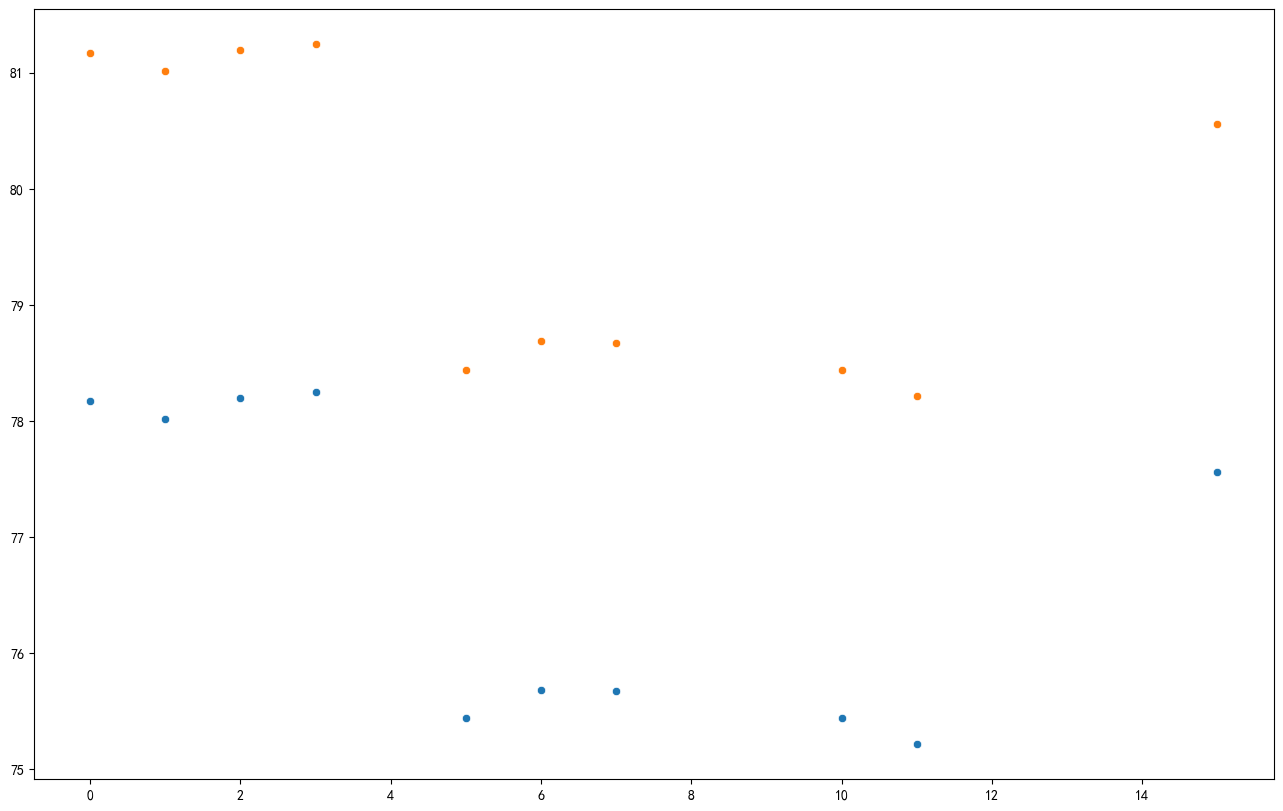

In [31]:
# 画图
import matplotlib.pyplot as plt
import seaborn as sns

df5 = df.copy()
df5 = df5[['ds','min_price','max_price','LOW_PRICE','LOW_PRICE','CREAT_DATE']]

print(df5.shape)
print(df5.head(10))
# 画图配置
plt.figure(figsize=(16,10))

def get_this_week_date(end_time):
    endtime = end_time
    # endtimeweek = datetime.datetime.strptime(endtime, '%Y-%m-%d')
    endtimeweek = endtime
    up_week = endtimeweek - datetime.timedelta(days=endtimeweek.weekday() )
    up_week_dates = [up_week + datetime.timedelta(days=i) for i in range(7)]
    up_week_dates = [date.strftime('%Y-%m-%d') for date in up_week_dates]
    return up_week_dates

# ds分组
end_times = df['ds'].unique()
for endtime in end_times:
    up_week_dates = get_this_week_date(endtime)
    print(up_week_dates)
    df6 = df5[df5['ds'].isin(up_week_dates)]
    print(df6.shape)
    print(df6.head(10))
    # sns画散点图
    sns.scatterplot(x=df6.index,y=df6['min_price'].values,data=df6)
    sns.scatterplot(x=df6.index,y=df6['max_price'].values,data=df6)
    sns.scatterplot(x=df6.index,y=df6['LOW_PRICE'].values,data=df6)
    sns.scatterplot(x=df6.index,y=df6['HIGH_PRICE'].values,data=df6)
    sns.scatterplot(x=df6.index,y=df6['HIGH_PRICE'].values,data=df6)